# ID 5059 Coursework 1
John Belcher-Heath (jbh6)

# Introduction

The task is to predict the price of a car from a subset of attributes from the Kaggle dataset.

I will complete the task following the ML checklist in the book, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. which is:

1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data
5. Explore models
6. Fine-tune models
7. Present solution
8. Launch/maintain

1 has already been done; we want to predict price of a car using attributes available to us.

# 2. Get the data

In the section the data will be obtained and read into a pandas.dataframe to explore. Note the smallest dataset will be explored since all we are doing is getting to know the data

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import os
import glob
from pathlib import Path

In [207]:
# folder_path: str = Path("C:\\Users\\johnb\\Documents\\git\\ID5059\\coursework_1\\used_cars_data_small") # Laptop
folder_path : str = r"/home/johnbh/personal_git/ID5059_coursework_1/used_cars_data_small" # Desktop
if not os.path.exists(folder_path):
    raise FileNotFoundError
os.chdir(folder_path)

file_names : list = [i for i in glob.glob("*.{}".format('csv'))]

def read_car_data(filepath : str) -> pd.DataFrame:
    """
    Reads a filepath and returns the dataframe
    :param filepath: The location of the file to read
    :return: returns the pandas dataframe
    """
    return pd.read_csv(filepath, index_col = "vin")



df = pd.concat(map(read_car_data, file_names))
data_original_length : int = len(df.index)

# 3. Explore the data

The data will now be inspected to explore what attributes are available to use. Additionally, with this output, attributes with large proportion of NAs can be identified and removed.

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25942 entries, 5NMS3CAD6LH250298 to 19UUB2F63JA006679
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   back_legroom             24540 non-null  object 
 1   bed                      237 non-null    object 
 2   bed_height               1676 non-null   object 
 3   bed_length               1676 non-null   object 
 4   body_type                25820 non-null  object 
 5   cabin                    276 non-null    object 
 6   city                     25942 non-null  object 
 7   city_fuel_economy        22037 non-null  float64
 8   combine_fuel_economy     0 non-null      float64
 9   daysonmarket             25942 non-null  int64  
 10  dealer_zip               25942 non-null  int64  
 11  description              25432 non-null  object 
 12  engine_cylinders         25179 non-null  object 
 13  engine_displacement      24418 non-null  float64
 14 

Let's explore all the numerical attributes with an actual numerical meaning.(index or listing_id has no meaning numerically). Additionally, all attributes from above which have 0 or approximately 0 non-null values will be dropped

In [ ]:
df = df.drop(columns=["dealer_zip", "listing_id", "cabin", "combine_fuel_economy", "is_certified", "is_cpo", "bed_height",
                     "bed_length", "is_oemcpo", "vehicle_damage_category"])

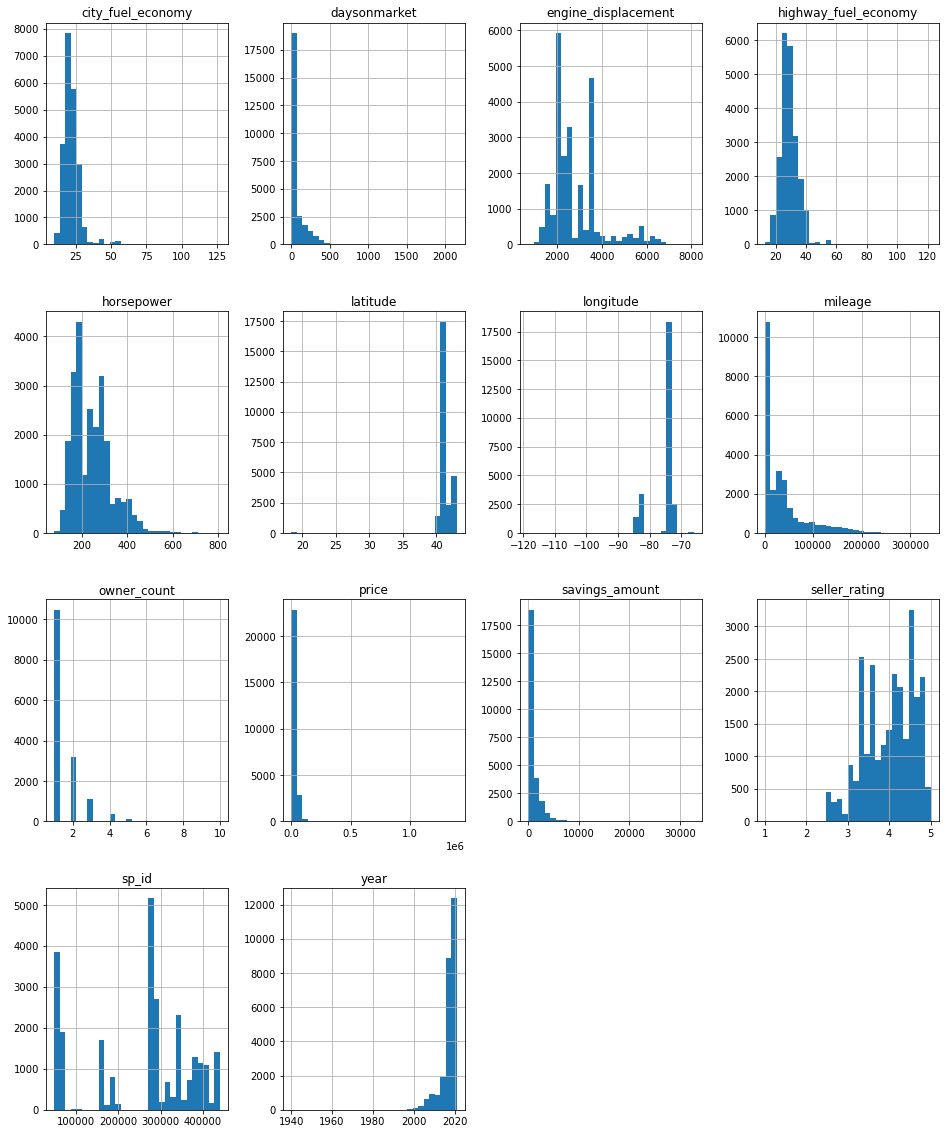

In [212]:
import matplotlib.pyplot as mpl
%matplotlib inline

df_numerical = df.select_dtypes(include=[np.int64, np.float64])
df_numerical.hist(figsize=(16,20), bins=30)
mpl.show()

Observations:


# 4. Prepare the data

Inspecting this list and using our contextual knowledge of cars, as well as the info available on the [kaggle page](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset). Certain attributes can be removed immediately, leaving ones that are believed to influence the price. Any attributes left will be further inspected before any models are used. The attributes left are given in a list below (including vin which acts as index). 

Note: data types are now defined to make sure any further exploration is done correctly.

In [169]:
# Attributes belived to influence price
desired_attributes : list = ["body_type", "city", "daysonmarket", "dealer_zip", "engine_cylinders", "engine_displacement",
                             "engine_type", "fleet", "frame_damaged", "franchise_dealer", "fuel_tank_volume", "has_accidents", "horsepower",
                             "is_cpo", "is_new", "is_oemcpo", "listed_date", "make_name", "owner_count", "power", "price",
                             "savings_amount", "seller_rating", "year", "torque"
                            ]
    
# Define datatypes of attributes to make sure any exploration is good.
data_types = {'vin' : str, 'back_legroom' : str, 'bed' : str, 'bed_height' : str,
              'bed_length' : str, 'body_type' : str, 'cabin' : str, 'city' : str,
              'city_fuel_economy' : np.float64, 'combine_fuel_economy' : np.float64,
              'daysonmarket' : np.int32, 'dealer_zip' : np.int32, 'description' : str, 
              'engine_cylinders' : str, 'engine_displacement' : np.float64,
              'engine_type' : str, 'exterior_color' : str, 'fleet' : bool, 'frame_damaged' : bool,
              'franchise_dealer' : bool, 'franchise_make' : str, 'front_legroom' : str,
              'fuel_tank_volume' : str, 'fuel_type' : str, 'has_accidents' : bool, 'height' : str,
            'highway_fuel_economy' : np.float64, 'horsepower' : np.float64, 'interior_color' : str, 'isCab' : bool,
            'is_certified' : bool, 'is_cpo' : bool, 'is_new' : bool, 'is_oemcpo' : bool, 'latitude' : np.float64, 'length' : str,
            'listed_date' : str, 'listing_color' : str, 'listing_id' : np.int32, 'longitude' : np.float64,
            'main_picture_url' : str, 'major_options' : str, 'make_name' : str, 'maximum_seating' : np.int32,
            'mileage' : np.int32, 'model_name' : str, 'owner_count' : np.int32, 'power' : str, 'price' : np.float64, 'salvage' : bool,
            'savings_amount' : np.int32 , 'seller_rating' : np.float64, 'sp_id' : np.int32, 'sp_name' : str, 'theft_title' : bool,
            'torque' : str, 'transmission' : str, 'transmission_display' : str, 'trimId' : np.int32, 'trim_name' : str,
            'vehicle_damage_category' : str, 'wheel_system' : str, 'wheel_system_display' : str,
            'wheelbase' : str, 'width' : str, 'year' : np.int32}

    
df1 = df[df.columns.intersection(desired_attributes)].convert_dtypes(data_types)

Next to check if the attributes chosen have NAs. Any attributes with entries that contain an NA will be shown below.

In [198]:
df1.keys()[df1.count() == len(df1.index)]

Index(['city', 'daysonmarket', 'dealer_zip', 'franchise_dealer', 'is_new',
       'listed_date', 'make_name', 'price', 'savings_amount', 'year'],
      dtype='object')

Clearly there is issues with some attributes. Let's first inspect the numerical attributes with NA issues.

In [193]:
df1[df1.select_dtypes(include=np.int64).isnull().any(axis=1)].select_dtypes(include=np.int64).isnull().any()

daysonmarket           False
dealer_zip             False
engine_displacement     True
horsepower              True
owner_count             True
price                  False
savings_amount         False
year                   False
dtype: bool

In [188]:
df1.loc[:, (df1.count() / len(df1.index)) > 0.95]

,body_type,city,daysonmarket,dealer_zip,engine_cylinders,engine_type,franchise_dealer,is_new,listed_date,make_name,price,savings_amount,seller_rating,year
vin,,,,,,,,,,,,,,
5NMS3CAD6LH250298,SUV / Crossover,Stamford,31,6902,I4,I4,True,True,2020-08-09,Hyundai,36650,0,4.258065,2020
1C4SDJCTXLC130802,SUV / Crossover,Bronx,48,10466,V8,V8,False,False,2020-07-23,Dodge,33950,6136,3.419753,2020
3FA6P0HD1LR222392,Sedan,Detroit,67,48207,I4,I4,True,True,2020-07-04,Ford,24692,0,4.5,2020
1C4RJFBG5KC677404,SUV / Crossover,Robbinsville,180,8691,V6,V6,True,False,2020-03-13,Jeep,34995,221,2.578947,2019
5NMS3CAD5LH248980,SUV / Crossover,Stamford,31,6902,I4,I4,True,True,2020-08-09,Hyundai,36650,0,4.258065,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4S3GTAB67L3731363,Hatchback,Acton,19,1720,H4,H4,True,True,2020-08-21,Subaru,20061,0,4.5,2020
WBA6D6C53JG388758,Sedan,Avenel,290,7001,V8,V8,False,False,2019-11-24,BMW,49981,8596,3.386667,2018
MAJ6S3KL2LC333774,SUV / Crossover,Clifton,200,7013,I4,I4,True,True,2020-02-22,Ford,28429,0,3.166667,2020


As most a large amount of the attributes are categorical or boolean, changing the remaining NAs to the average of the column would not make much sense. Furthermore, since the dataset is very large, removing NAs is unlikely to heavily impact the model. However to make sure the one type of car or manufactor is not being discrimanted against before they're removed the entries with NAs will be inspected.

In [154]:
car_makes_with_NA = df1[df1.isnull().any(axis=1)].make_name.unique()
df_prepared = df1[~df1.isnull().any(axis=1)]
car_makes_no_NA = df_prepared.make_name.unique()

(set(car_makes_no_NA) and set(car_makes_with_NA)) == set(car_makes_with_NA)

True

This means all car makes are being represented still even when NA rows are removed.

Now the data has been filtered, the exploration of relationships can begin. Note that only 4% of the entries have been removed.

In [155]:
round(len(df_prepared.index) / data_original_length, 2)

0.96

In [156]:
used_cars_prices = df_prepared["price"].copy()
used_cars_prices.head()

vin
5NMS3CAD6LH250298    36650
1C4SDJCTXLC130802    33950
3FA6P0HD1LR222392    24692
1C4RJFBG5KC677404    34995
5NMS3CAD5LH248980    36650
Name: price, dtype: Int64

In [157]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
